In [176]:
import pandas as pd
import seaborn as sns
from ipywidgets import widgets
from IPython.display import display

In [180]:
import numpy as np
from glob import glob
from json import loads

df = None
def update_df():
    global df

    glob_path = "./implementation/test/history/**/*.json"

    runs = []
    for run_output_filepath in glob(glob_path, recursive=True):
        with open(run_output_filepath) as run_output:
            run_json = loads(run_output.read())
            runs.append(run_json)

    if not runs:
        raise Exception("No runs found")
    else:
        print(f"Found {len(runs)} runs")


    newDF = pd.DataFrame(runs)
    newDF = newDF.rename(columns={
        "lang": "language"
    })

    newDF = newDF.assign(
        # Super fragile replace but works for now
        payload=lambda df: df["payload"].map(
            lambda payload: loads(payload.replace(";", ","))),

        runtime=lambda df: df["runtime"].astype(float),
        roundTripTime=lambda df: df["roundTripTime"].astype(float),
        newcontainer=lambda df: df["newcontainer"].astype(int),

        filter=lambda df: df["payload"].map(
            lambda payload: f"{payload['filter']} x {payload.get('repeats', 1)}"),
        filename=lambda df: df["payload"].map(lambda payload: payload["key"]),
        containerState=lambda df: np.where(
            df["newcontainer"] == 1, "cold", "hot"
        ),
        language=lambda df: df["language"].map({
            "java": "Java",
            "node.js": "JavaScript",
        }),

        pixelDimensions=lambda df: df["filename"].map(
            lambda filename: tuple(map(int, filename.split("@")[0].split("x")))),
        pixelAmount=lambda df: df["pixelDimensions"].map(
            lambda dimensions: dimensions[0] * dimensions[1]),

        shortName=lambda df:
        df["filename"].map(lambda filename: filename.split("-")[1].strip()[:-4]),

        fileID=lambda df: df["shortName"] + " " + df["pixelDimensions"].astype(str),
    )
    df = newDF

update_df()

display(widgets.Button(description="Update Data Frame",
        button_style="success", icon="refresh",
        on_click=lambda _: update_df(), layout=widgets.Layout(width="30%")))


Found 4151 runs


Button(button_style='success', description='Update Data Frame', icon='refresh', layout=Layout(width='30%'), st…

In [131]:
def create_global_widgets():
    global_widgets = {}
    for (columnName, columnData) in df.items():
        try:
            if type(columnName) == str:
                global_widgets[columnName] = widgets.Dropdown(
                    options=columnData.unique(),
                    description=columnName,
                    disabled=False,
                )
        except Exception as e:
            print(columnName, ":", e)
    return global_widgets

columns_to_display = {
    "cpuType", "language", "functionName", "containerState", "filter",
    "pixelAmount", "shortName", "fileID", "filename",
}
global_widgets = create_global_widgets()
display(*(
    global_widget
    for column, global_widget
    in global_widgets.items()
    if column in columns_to_display
))

payload : unhashable type: 'dict'
key : Invalid selection: value not found
bucket : Invalid selection: value not found
message : Invalid selection: value not found


Dropdown(description='cpuType', options=('Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63', 'Intel(R) Xeon(R) …

Dropdown(description='language', options=('Java', 'JavaScript'), value='Java')

Dropdown(description='functionName', options=('imageProcessingJava', 'imageProcessingJavaScript'), value='imag…

Dropdown(description='filter', options=('flipVertical x 1', 'greyscale x 1', 'soften x 8', 'soften x 1'), valu…

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

Dropdown(description='containerState', options=('hot', 'cold'), value='hot')

Dropdown(description='pixelAmount', options=(2500, 65536, 326200, 2304000, 8294400, 19961856), value=2500)

Dropdown(description='shortName', options=('osu', 'husky', 'vietfood', 'deathstar', 'mountains', 'lanterns'), …

Dropdown(description='fileID', options=('osu (50, 50)', 'husky (256, 256)', 'vietfood (700, 466)', 'deathstar …

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

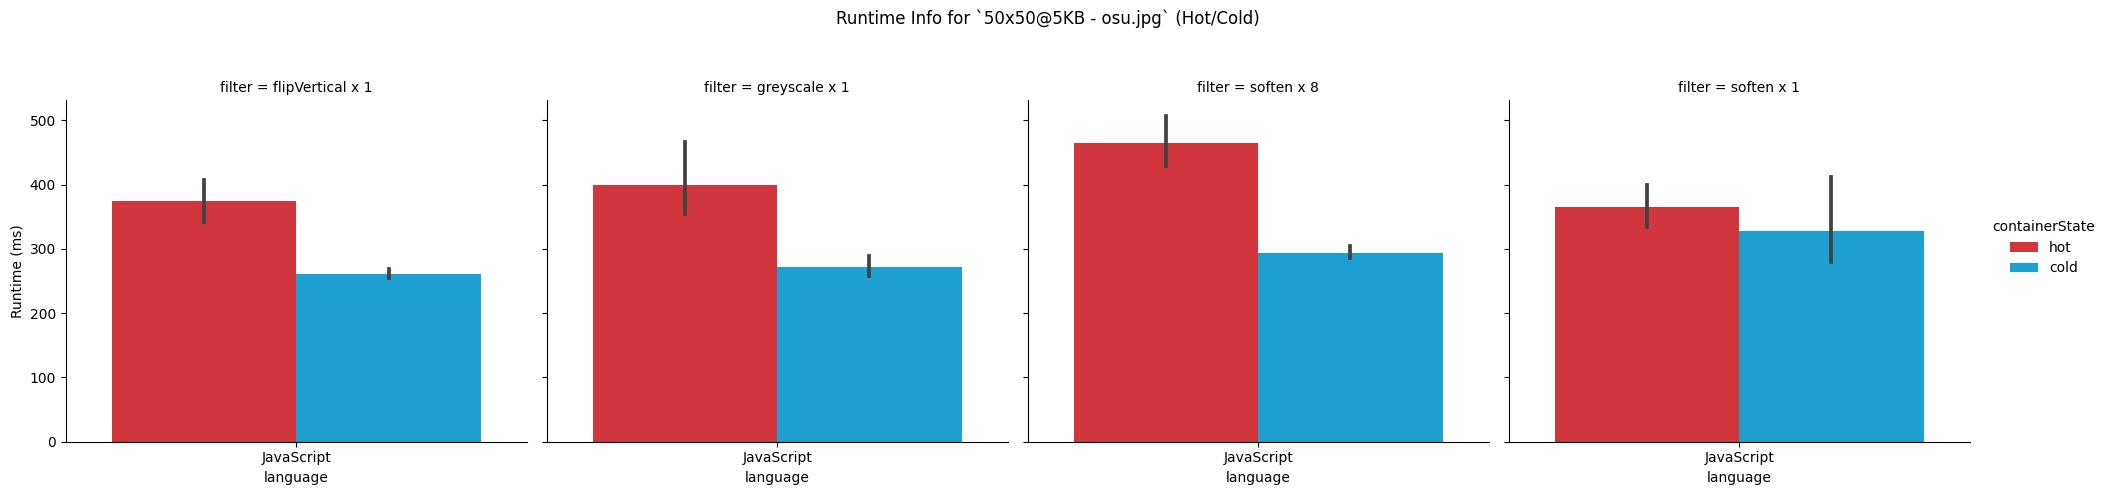

In [175]:
filename = global_widgets["filename"].value

data = df[
    (df["filename"] == filename) &
    (df["language"] == "JavaScript") &
    True
]

results = sns.catplot(
    data,
    kind="bar",
    x="language", y="runtime",
    hue="containerState",
    col="filter", palette=["#eb1c24", "#00adef"],
)
results.set_ylabels("Runtime (ms)")
results.figure.subplots_adjust(top=0.8)
results.figure.suptitle(f"Runtime Info for `{filename}` (Hot/Cold)")

display(global_widgets["filename"])
results

Dropdown(description='filename', index=5, options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466…

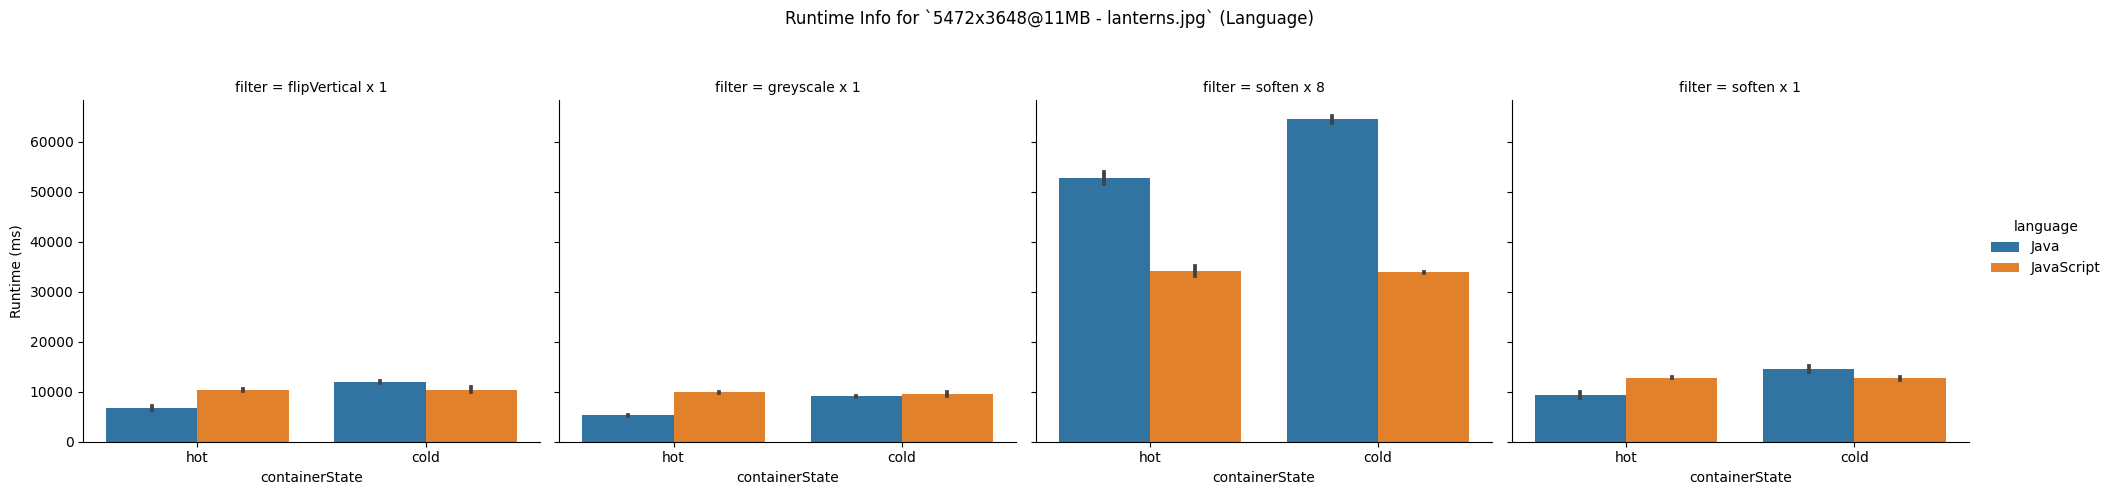

In [161]:
filename = global_widgets["filename"].value

data = df[
    (df["filename"] == filename)
]

results = sns.catplot(
    data,
    kind="bar",
    x="containerState", y="runtime",
    hue="language",
    col="filter",
)
results.set_ylabels("Runtime (ms)")
results.figure.subplots_adjust(top=0.8)
results.figure.suptitle(f"Runtime Info for `{filename}` (Language)")

display(global_widgets["filename"])
results

In [169]:
update_df()

grouped_columns = [
    # "cpuType",
    "fileID", "filter", "containerState", "language",
]
data = df[
    # df["shortName"].isin(["mountains", "lanterns"]) &
    df["filter"].isin(["soften x 8"]) &
    # df["containerState"].isin(["cold"]) &
    True
]

runtime_results = data.groupby(grouped_columns)["runtime"] \
    .agg(["mean", "std", "count"])
runtime_results = runtime_results.rename(columns={
    "mean": "average runtime (ms)",
    "std": "standard deviation",
    "count": "sample size",
})

runtime_results

Found 3851 runs


average runtime (ms)  \
fileID                 filter     containerState language                           
deathstar (1920, 1200) soften x 8 cold           Java                 9596.689655   
                                                 JavaScript           4054.703704   
                                  hot            Java                 4659.258065   
                                                 JavaScript           4223.741935   
husky (256, 256)       soften x 8 cold           Java                 3572.678571   
                                                 JavaScript            684.178571   
                                  hot            Java                  408.718750   
                                                 JavaScript            595.781250   
lanterns (5472, 3648)  soften x 8 cold           Java                64020.321429   
                                                 JavaScript          33805.259259   
                                  hot            Java                52740.468750   
                                                 JavaScript          34135.312500   
mountains (3840, 2160) soften x 8 cold           Java                25939.000000   
                                                 JavaScript          13226.777778   
                                  hot            Java                18959.709677   
                                                 JavaScript          13504.303030   
osu (50, 50)           soften x 8 cold           Java                 3205.178571   
                                                 JavaScript            294.461538   
                                  hot            Java                  159.843750   
                                                 JavaScript            465.323529   
vietfood (700, 466)    soften x 8 cold           Java                 4498.071429   
                                                 JavaScript            978.407407   
                                  hot            Java                 1096.656250   
                                                 JavaScript           1092.875000   

                                                             standard deviation  \
fileID                 filter     containerState language                         
deathstar (1920, 1200) soften x 8 cold           Java                423.578472   
                                                 JavaScript          120.213853   
                                  hot            Java                800.475316   
                                                 JavaScript          351.482382   
husky (256, 256)       soften x 8 cold           Java                372.516970   
                                                 JavaScript          980.900646   
                                  hot            Java                175.204072   
                                                 JavaScript           78.470350   
lanterns (5472, 3648)  soften x 8 cold           Java               2464.972707   
                                                 JavaScript          529.130680   
                                  hot            Java               3182.141397   
                                                 JavaScript         2853.796955   
mountains (3840, 2160) soften x 8 cold           Java                750.606326   
                                                 JavaScript          939.886382   
                                  hot            Java               2775.145104   
                                                 JavaScript         1221.716479   
osu (50, 50)           soften x 8 cold           Java                139.663631   
                                                 JavaScript           26.628152   
                                  hot            Java                 86.475098   
                                                 JavaScript          118.384254   
vietfood (700, 466)    s

In [ ]:
hot_results = sns.catplot(
    df[df["containerState"] == "hot"], x="fileID", y="runtime", hue="language",
    col="filter", kind="bar",
)
hot_results.set_axis_labels("File ID", "Runtime (ms)")
hot_results.set_titles("Filter: {col_name}")
hot_results.figure.subplots_adjust(top=0.8)
hot_results.figure.suptitle("Runtimes for Hot Containers")
hot_results.set_xticklabels(rotation=80)

hot_results

In [ ]:
cold_results = sns.catplot(
    df[df["containerState"] == "cold"], x="pixelAmount", y="runtime", hue="language",
    col="filter", kind="bar",
)
cold_results.set_axis_labels("Filename", "Runtime (ms)")
cold_results.set_titles("Filter: {col_name}")
cold_results.figure.subplots_adjust(top=0.8)
cold_results.figure.suptitle("Runtimes for Cold Containers")
cold_results.set_xticklabels(rotation=80)

cold_results

In [ ]:
hot_cold_results = sns.catplot(
    df, x="shortName", y="runtime", hue="language",
    col="filter", row="containerState", kind="bar",
)
hot_cold_results.set_axis_labels("Pixel Amount", "Runtime (ms)")
hot_cold_results.set_titles("Filter: {col_name}\nContainer State: {row_name}")
hot_cold_results.figure.subplots_adjust(top=0.9)
hot_cold_results.figure.suptitle("Runtimes for Hot/Cold Containers")

In [ ]:
hot_cold_javascript = sns.catplot(
    df[
        (df["language"] == "JavaScript")
        & (df["filter"] == "soften")
    ],
    x="shortName", y="runtime",
    hue="containerState",
    kind="bar",
)
hot_cold_javascript.set(title="JavaScript Runtimes for Hot/Cold Containers")
hot_cold_javascript.set_xlabels("Filename")
hot_cold_javascript.set_ylabels("Runtime (ms)")
hot_cold_javascript.set_xticklabels(rotation=30)

hot_cold_javascript